Script CNN pal

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


2024-03-18 09:27:26.706447: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 09:27:26.745264: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 09:27:27.643641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_dir = '/home/arthur_boddaert/pal_CNN/test_CNN/pictures/'

In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.0953,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10500 files belonging to 3 classes.
Using 9500 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.0953,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10500 files belonging to 3 classes.
Using 1000 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['scenario_1', 'scenario_2', 'scenario_3']


In [7]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache('/home/arthur_boddaert/pal_CNN/test_CNN/cache/').prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache('/home/arthur_boddaert/pal_CNN/test_CNN/cache/').prefetch(buffer_size=AUTOTUNE)

In [9]:
save_dir = "/home/arthur_boddaert/pal_CNN/models/best_model.keras"
bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

Créer le modèle

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/home/arthur_boddaert/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,627 (24.59 MB)

 Trainable params: 6,446,627 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[bestmodel]
)


Epoch 1/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - accuracy: 0.5493 - loss: 2.1596 - val_accuracy: 0.7617 - val_loss: 0.5964
Epoch 2/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 149ms/step - accuracy: 0.7797 - loss: 0.5602 - val_accuracy: 0.8057 - val_loss: 0.5312
Epoch 3/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - accuracy: 0.8190 - loss: 0.4790 - val_accuracy: 0.8350 - val_loss: 0.4489
Epoch 4/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 149ms/step - accuracy: 0.8372 - loss: 0.4222 - val_accuracy: 0.8584 - val_loss: 0.3754
Epoch 5/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.8523 - loss: 0.3707 - val_accuracy: 0.8711 - val_loss: 0.3258
Epoch 6/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.8688 - loss: 0.3283 - val_accuracy: 0.8770 - val_loss: 0.3048
Epoch 7/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.8744 - loss: 0.3038 - val_accuracy: 0.8887 - val_loss: 0.2716
Epoch 8/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.8857 - loss: 0

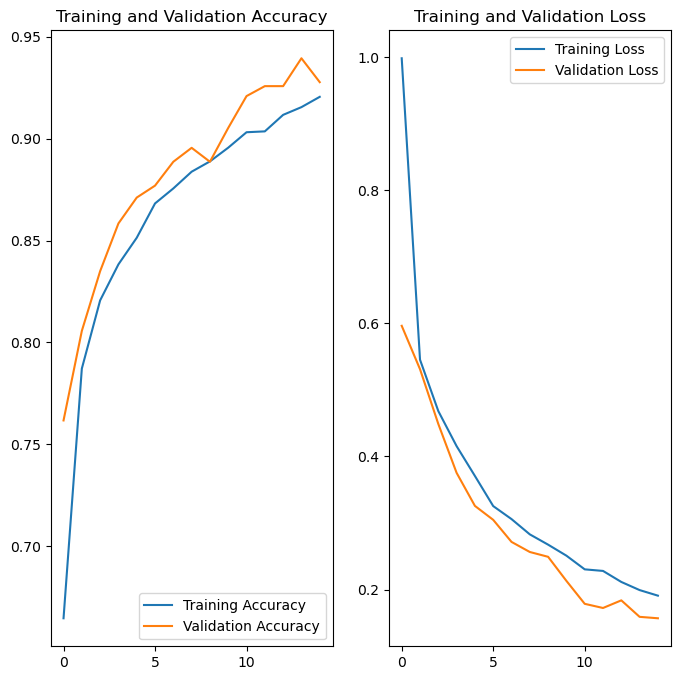

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)

2024-03-18 09:39:38.824311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


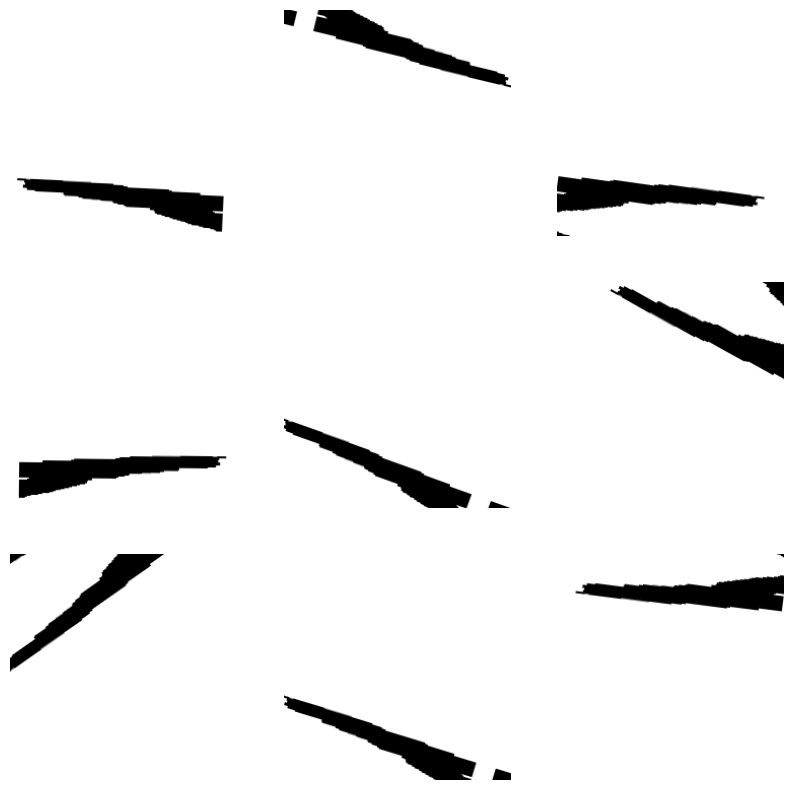

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
save_dir = "/home/arthur_boddaert/pal_CNN/models/best_model_augmented.keras"
bestmodel_augmented = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

In [20]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,627 (24.59 MB)

 Trainable params: 6,446,627 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[bestmodel_augmented]
)

Epoch 1/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 58s 190ms/step - accuracy: 0.5412 - loss: 1.9957 - val_accuracy: 0.7725 - val_loss: 0.5974
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 54s 182ms/step - accuracy: 0.7785 - loss: 0.5528 - val_accuracy: 0.8105 - val_loss: 0.4689
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - accuracy: 0.8105 - loss: 0.4608 - val_accuracy: 0.8486 - val_loss: 0.4053
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 53s 180ms/step - accuracy: 0.8417 - loss: 0.4025 - val_accuracy: 0.8594 - val_loss: 0.3420
Epoch 5/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - accuracy: 0.8567 - loss: 0.3547 - val_accuracy: 0.8623 - val_loss: 0.3432
Epoch 6/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 52s 174ms/step - accuracy: 0.8699 - loss: 0.3226 - val_accuracy: 0.8662 - val_loss: 0.3223
Epoch 7/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - accuracy: 0.8764 - loss: 0.3040 - val_accuracy: 0.8906 - val_loss: 0.2791
Epoch 8/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 52s 176ms/step - accuracy: 0.8829 - loss: 0

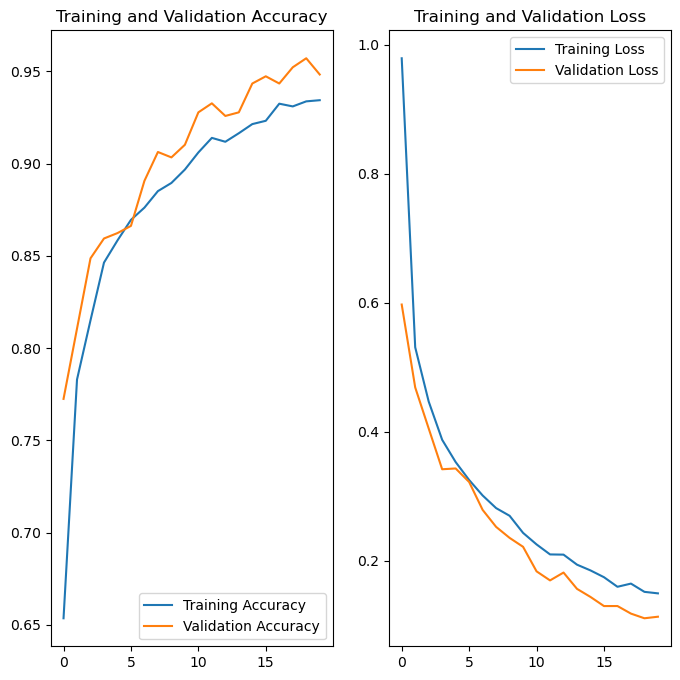

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [25]:
test_dir = '/home/arthur_boddaert/pal_CNN/test_CNN/test/'

In [26]:
all_scores = []
for picture in os.listdir(test_dir):
    print(picture)
    img = tf.keras.utils.load_img(
        f'{test_dir}{picture}', target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    all_scores.append(np.max(score))

S3_3723_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
S1_3671_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3938_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3824_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S3_3753_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S2_3810_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3813_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3738_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3851_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3709_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3543_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3618_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S2_3690_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3691_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3845_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S1_3532_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3512_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S2_3917_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3695_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3586_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3575_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3820_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3980_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3670_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3903_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3585_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3859_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3628_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3732_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3867_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3969_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3600_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3744_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3696_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3530_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3875_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3644_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3869_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S1_3781_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S2_3800_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3578_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S3_3976_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3630_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3767_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3536_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3529_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3737_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3711_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3635_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3891_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3721_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3762_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3586_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3754_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3923_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3941_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3946_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3782_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3568_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3677_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3631_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3786_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3626_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3829_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3639_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3626_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3560_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3953_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3936_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S2_3976_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3537_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3922_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3862_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3531_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S1_3798_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3868_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3642_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3939_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S3_3500_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3551_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3839_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3511_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S2_3546_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
S3_3710_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S3_3837_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3993_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3611_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3947_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3519_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3968_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3951_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3974_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3756_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S2_3954_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3754_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3516_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3736_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S2_3565_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3721_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3920_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
S3_3975_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3503_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S2_3961_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3833_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3501_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3873_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3928_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3845_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3789_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S3_3888_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S1_3693_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
S2_3699_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3994_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S2_3816_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3748_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3876_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3675_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S1_3665_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3681_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3747_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3907_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S3_3910_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3777_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3937_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3997_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3813_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3519_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3897_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3737_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3965_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3909_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3534_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S3_3898_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3884_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3945_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3935_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3733_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3951_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3997_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3516_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3672_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3799_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3820_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S2_3962_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
S2_3850_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
S3_3752_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
S2_3504_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
S2_3873_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
S1_3998_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
S2_3795_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S1_3930_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S2_3671_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S2_3911_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3584_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3525_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
S3_3917_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
S1_3938_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
S1_3977_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
S2_3825_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
S3_3840_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
S3_3652_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
S1_3817_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3613_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3912_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3666_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3806_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3628_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3814_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3863_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3923_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3647_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3952_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3643_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3776_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3764_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3749_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3948_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S2_3930_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S2_3564_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S2_3518_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3824_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3821_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3536_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3726_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3700_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3805_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3612_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3923_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3642_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S1_3600_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3610_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3698_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3998_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3787_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3666_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S1_3917_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3561_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3683_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S1_3856_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
S2_3770_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S2_3912_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3784_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3791_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3942_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S1_3632_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
S1_3879_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3594_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3697_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S1_3975_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3665_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3704_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3786_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
S1_3878_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S2_3524_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3884_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
S2_3730_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3597_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3882_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3515_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3676_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3947_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3573_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3704_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S2_3983_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3984_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S2_3678_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S1_3790_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3666_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3828_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3711_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3811_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3796_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S1_3542_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3734_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3878_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3716_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3606_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3846_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3552_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3550_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3535_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
S3_3731_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3694_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3527_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S2_3798_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3927_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3633_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3955_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3820_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3983_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3646_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
S3_3700_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3720_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3709_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3643_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3961_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3736_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S2_3515_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3587_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3602_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3904_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3801_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S1_3893_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3721_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3999_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3762_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3881_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3567_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3534_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S2_3881_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
S2_3629_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
S1_3804_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
S1_3506_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
S1_3678_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3599_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
S3_3860_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S3_3978_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S2_3589_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S1_3660_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S1_3584_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S1_3920_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3974_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3661_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3758_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3619_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3740_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3896_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S2_3975_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3963_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
S1_3971_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3555_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3620_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3926_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S3_3825_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S2_3537_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S1_3608_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S3_3513_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S3_3829_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3925_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S1_3725_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3797_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
S2_3745_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S1_3885_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S1_3847_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S2_3855_count.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
S3_3553_co

In [27]:
print(np.mean(all_scores))

0.9218039


In [28]:
loaded_model = tf.keras.models.load_model('/home/arthur_boddaert/pal_CNN/models/best_model.keras')

La partie augmentation des données ne semble pas pertinente tel qu'elle est actuellement.